<a href="https://colab.research.google.com/github/JoDeMiro/DeepLearningIntroduction/blob/main/06_LSTM_with_Stock_Market_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Leírás

Itt a Keras API LSTM osztályának a használatát vizsgálom meg idősoroson adatokon.

Konkrét tervem van azzal, hogy tőzsdei idősorokon mutatom be, mert ezeken azután be fogom tudni mutatni az egyváltozós modelhez képest elérhető javulást a becsült és a valós érték között.

Ráadásul ez átmenetet fog képezni az egyváltozós modellből a töbválltozós modell irányába.

In [28]:
# !pip install --upgrade pandas
# !pip install --upgrade pandas-datareader

In [82]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

plt.style.use('fivethirtyeight')

# Get the Stock quote

In [83]:
df = web.DataReader('AAPL', data_source='yahoo', start='2012-01-01', end='2022-01-15')

In [84]:
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,14.732143,14.607143,14.621429,14.686786,302220800.0,12.591939
2012-01-04,14.810000,14.617143,14.642857,14.765714,260022000.0,12.659610
2012-01-05,14.948214,14.738214,14.819643,14.929643,271269600.0,12.800157
2012-01-06,15.098214,14.972143,14.991786,15.085714,318292800.0,12.933967
2012-01-09,15.276786,15.048214,15.196429,15.061786,394024400.0,12.913448
...,...,...,...,...,...,...
2022-01-10,172.500000,168.169998,169.080002,172.190002,106765600.0,172.190002
2022-01-11,175.179993,170.820007,172.320007,175.080002,76138300.0,175.080002
2022-01-12,177.179993,174.820007,176.119995,175.529999,74805200.0,175.529999


In [85]:
df.shape

(2527, 6)

# Vizualizáció

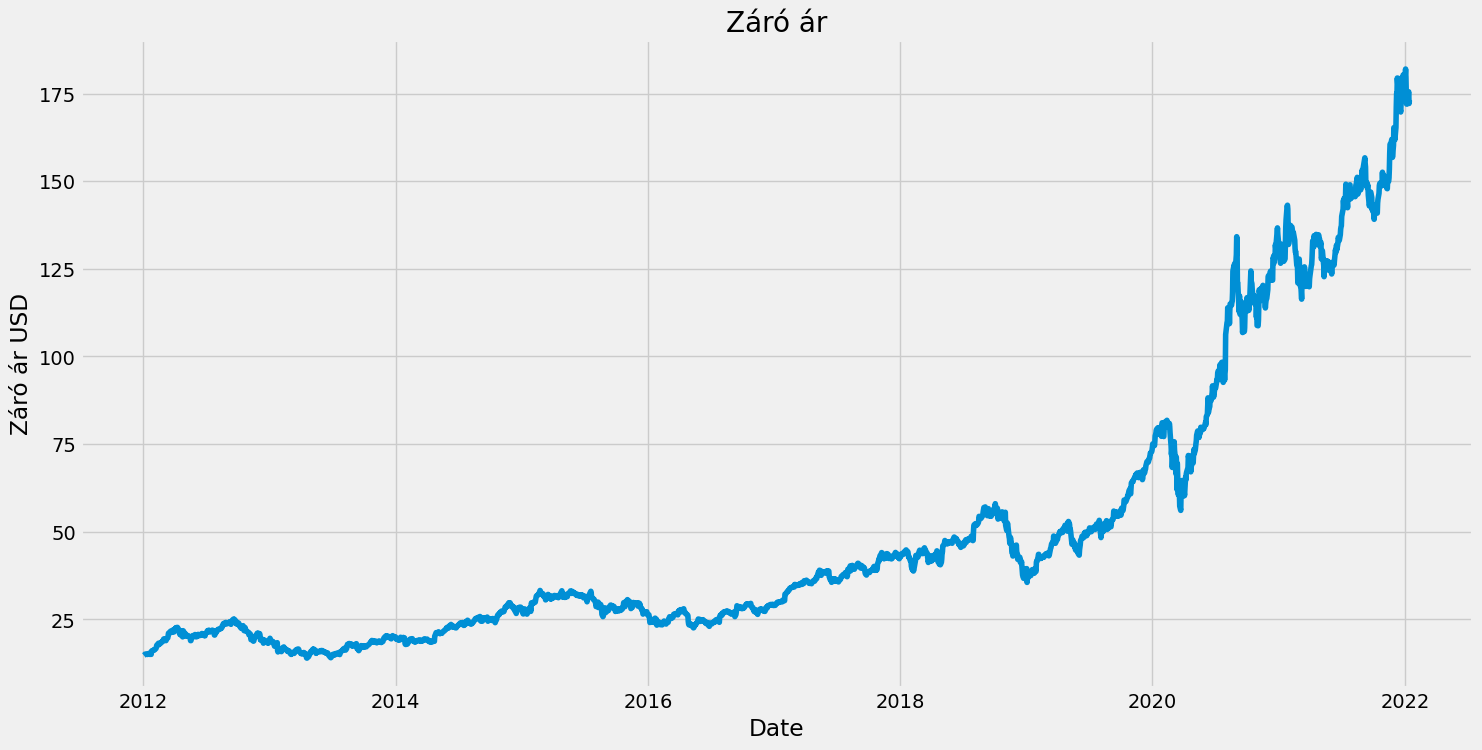

In [86]:
plt.figure(figsize=(16,8))
plt.title('Záró ár')
plt.plot(df['Close'])
plt.xlabel('Date')
plt.ylabel('Záró ár USD')
plt.show()

## Új Pandas DataFrame csak a 'Close' oszlop alapján

In [87]:
data = df.filter(['Close'])

## Kérjük el NumPy tömbben

In [88]:
dataset = data.values

## Vágjuk ketté az idősort egy ponton tanuló és teszt adatokra

In [89]:
training_data_len = math.ceil(len(dataset) * 0.8)

training_data_len

2022

## Normalizáljuk az adatokat - transzformáljuk [0, 1] intervallumra

In [90]:
scaler = MinMaxScaler(feature_range=(0,1))

In [91]:
scaled_data = scaler.fit_transform(dataset)

## Ime egy tipikus hiba!

Na itt elcsúszohatott és el el is csúszik az egész, mivel a MinMax átalakítást az egész mintán végeztem el és csak most fogom leválogatni tanuló és teszt mintára.

Na de menjünk szépen sorjában és nézzük meg, hogy így milyen eredményt kapunk, majd meg fogom csinálni másképpen is. De most szólok, ez a tipikus hiba. Hányszor láttam embereket belesétálni ebbe.

In [92]:
train_data = scaled_data[0:training_data_len, :]

## Vágjuk ketté az adatokat x_train and y_train adatokra

Idősoroknál nem árt ha közben megörízzük a sorrendet - Másik tipikus hiba amit el lehet véteni idősorok esetében.



```
for i in range(window_size, len(train_data)):
  x_train.append(train_data[i-window_size:i, 0])
  y_train.append(train_data[i,0])
```



```
# Érdemes megfigyelni, y-t i-vel indexelem,
# x-et viszont i-ig,
#
# ezért gyakorlatilag t+1 relációt fogok becsülni,
# window_size hosszú vektorral.
```





In [93]:
x_train = []
y_train = []

window_size = 60

for i in range(window_size, len(train_data)):
  x_train.append(train_data[i-window_size:i, 0])
  y_train.append(train_data[i,0])

In [94]:
print(type(x_train))
print(type(x_train[1]))
print(x_train[1].shape)
print(x_train[1])

<class 'list'>
<class 'numpy.ndarray'>
(60,)
[0.00486851 0.00584391 0.00677256 0.00663019 0.00695107 0.00680444
 0.00655793 0.00622217 0.00726133 0.00819848 0.00790947 0.0063263
 0.00783722 0.00634968 0.01192796 0.01149658 0.01205972 0.01327737
 0.01401476 0.01395314 0.01372576 0.01469479 0.01560643 0.01663922
 0.01830739 0.02181161 0.02186474 0.02381555 0.02527333 0.0227679
 0.02373267 0.02371354 0.02641875 0.02603411 0.026746   0.02802528
 0.02873719 0.03078787 0.03228178 0.03271317 0.03286405 0.03030973
 0.02969346 0.02978484 0.03218616 0.03286193 0.03431335 0.03773469
 0.04229932 0.04144504 0.04144716 0.04474738 0.04578017 0.04504489
 0.04437338 0.04367423 0.04599691 0.04759072 0.04825798 0.04660893]


In [95]:
print(type(y_train))
print(type(y_train[1]))
print(y_train[0].shape)
print(y_train[0])
print(y_train[1])

<class 'list'>
<class 'numpy.float64'>
()
0.04660893460974819
0.04441800167645807


## Alakítsuk át az x_train és y_train listákat NumPy tömbökké

In [96]:
X_train, y_train = np.array(x_train), np.array(y_train)

print(X_train.shape)
print(y_train.shape)

(1962, 60)
(1962,)


## By the way - hogy is néz ez ki?

In [133]:
print(X_train.shape)
print(y_train.shape)

(1962, 60)
(1962,)


In [136]:
print(X_train[-1])
print(y_train[-1])
print(y_train[-2])
print(y_train[-3])

[0.26867982 0.27477873 0.2739606  0.27875046 0.27934549 0.28380812
 0.28748235 0.27891409 0.27886947 0.28705095 0.29755301 0.30005207
 0.29950169 0.2996653  0.30292302 0.30397921 0.30704354 0.3066865
 0.31042024 0.30769806 0.31233918 0.31433248 0.31312758 0.30851619
 0.3067609  0.30641875 0.31324656 0.31015249 0.31543325 0.31455561
 0.30995911 0.3029528  0.30635924 0.31207139 0.31970249 0.31406474
 0.3163853  0.31979174 0.32081814 0.32630718 0.33331349 0.33413166
 0.33313499 0.3335515  0.33268875 0.33947193 0.33987355 0.34826331
 0.34809966 0.35065823 0.3538267  0.36379325 0.35944961 0.36297508
 0.36087768 0.36801787 0.37759764 0.37863889 0.3885013  0.38213462]
0.38014132260782096
0.38213462328987924
0.3885013007536481


## Reshape the data

Erre a lépésre azért van szükség mert a Keras model egy picit más formában várja majd az adatokat.

In [97]:
X_train_reshaped = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

X_train_reshaped.shape

(1962, 60, 1)

In [98]:
print(X_train_reshaped[1][1:10])

[[0.00584391]
 [0.00677256]
 [0.00663019]
 [0.00695107]
 [0.00680444]
 [0.00655793]
 [0.00622217]
 [0.00726133]
 [0.00819848]]


# Build the LSTM model

Keep it simple - kezdjük valmai egyszerűvel.

In [99]:
model = Sequential()

model.add(LSTM(50, return_sequences=True, input_shape = (X_train_reshaped.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(25))
model.add(Dense(1))

## Compile the model

In [100]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [101]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 60, 50)            10400     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_6 (Dense)             (None, 25)                1275      
                                                                 
 dense_7 (Dense)             (None, 25)                650       
                                                                 
 dense_8 (Dense)             (None, 1)                 26        
                                                                 
Total params: 32,551
Trainable params: 32,551
Non-trainable params: 0
_________________________________________________________________


## Visualise the arch. of mod.

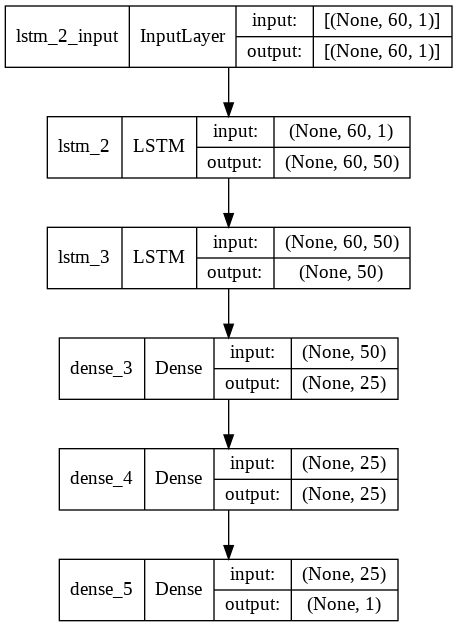

In [59]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_plot1.png', show_shapes=True, show_layer_names=True)

## Train the model

In [102]:
history = model.fit(X_train_reshaped, y_train, batch_size=100, epochs=10)

Epoch 1/10
20/20 [==============================] - 6s 97ms/step - loss: 0.0027
Epoch 2/10
20/20 [==============================] - 2s 92ms/step - loss: 1.8432e-04
Epoch 3/10
20/20 [==============================] - 2s 94ms/step - loss: 7.8654e-05
Epoch 4/10
20/20 [==============================] - 2s 94ms/step - loss: 6.1365e-05
Epoch 5/10
20/20 [==============================] - 2s 95ms/step - loss: 5.7787e-05
Epoch 6/10
20/20 [==============================] - 2s 96ms/step - loss: 5.7689e-05
Epoch 7/10
20/20 [==============================] - 2s 102ms/step - loss: 5.6354e-05
Epoch 8/10
20/20 [==============================] - 2s 106ms/step - loss: 5.5165e-05
Epoch 9/10
20/20 [==============================] - 2s 97ms/step - loss: 5.5294e-05
Epoch 10/10
20/20 [==============================] - 2s 95ms/step - loss: 5.3618e-05


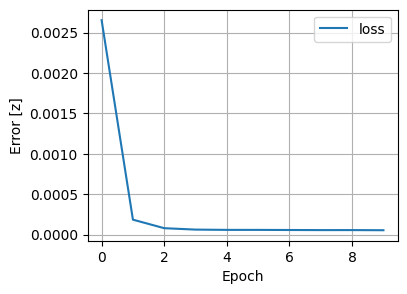

In [107]:
def plot_loss(history):
  plt.figure(figsize=(4, 3))
  plt.plot(history.history['loss'], label='loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error [z]')
  plt.legend()
  plt.grid(True)

plt.style.use('default')
plot_loss(history)

## Create the testing data set

Ezt korábban is megcsinálhattam volna, de jobban tetszik, hogy elöbb a modelt tanítottam fel.

```
# Nem ám elfelejteni, hogy már [0, 1] intervallumra skáláztam az adatokat. Ami hiba.
```



In [108]:
test_data = scaled_data[training_data_len - window_size: , :]

print(window_size)
print(type(scaled_data))
print(type(test_data))
print(scaled_data.shape)
print(test_data.shape)

60
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(2527, 1)
(565, 1)


In [110]:
X_test = []
y_test = dataset[training_data_len: , :]

for i in range(window_size, len(test_data)):
  X_test.append(test_data[i-window_size:i, 0])

In [111]:
print(type(y_test))
print(y_test.shape)
print(y_test[1])

print(type(X_test))
print(X_test[1].shape)
print(X_test[1])

<class 'numpy.ndarray'>
(505, 1)
[79.68250275]
<class 'list'>
(60,)
[0.2739606  0.27875046 0.27934549 0.28380812 0.28748235 0.27891409
 0.27886947 0.28705095 0.29755301 0.30005207 0.29950169 0.2996653
 0.30292302 0.30397921 0.30704354 0.3066865  0.31042024 0.30769806
 0.31233918 0.31433248 0.31312758 0.30851619 0.3067609  0.30641875
 0.31324656 0.31015249 0.31543325 0.31455561 0.30995911 0.3029528
 0.30635924 0.31207139 0.31970249 0.31406474 0.3163853  0.31979174
 0.32081814 0.32630718 0.33331349 0.33413166 0.33313499 0.3335515
 0.33268875 0.33947193 0.33987355 0.34826331 0.34809966 0.35065823
 0.3538267  0.36379325 0.35944961 0.36297508 0.36087768 0.36801787
 0.37759764 0.37863889 0.3885013  0.38213462 0.38014132 0.38594273]


## List -> Numpy

In [112]:
X_test = np.array(X_test)

## Reshape the data

In [113]:
x_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [114]:
print(type(X_test))
print(X_test.shape)
print(X_test[1][1:5])

<class 'numpy.ndarray'>
(505, 60)
[0.27875046 0.27934549 0.28380812 0.28748235]


## Get the models predicted price values

In [115]:
predictions = model.predict(X_test)

In [117]:
print(predictions.shape)
print(predictions[0])

(505, 1)
[0.379488]


## Invert the scaled values to the original

In [118]:
predictions_inverted = scaler.inverse_transform(predictions)

In [119]:
predictions_inverted[0]

array([77.7252], dtype=float32)

## Measure the error of the prediction

In [121]:
root_mean_square_error = np.sqrt( np.mean( predictions_inverted - y_test )**2 )

In [122]:
root_mean_square_error

5.850942426624865

## Create a new dataframe

In [123]:
train = data[:training_data_len]
valid = data[training_data_len:]

print(type(valid))
print(valid.shape)
print(valid.columns)

valid['Predictions'] = predictions_inverted

print(valid.shape)
print(valid.columns)

<class 'pandas.core.frame.DataFrame'>
(505, 1)
Index(['Close'], dtype='object')
(505, 2)
Index(['Close', 'Predictions'], dtype='object')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Visualize the data



```
# Egy gyors emlkékeztető

Csuda szépnek tűnhet a grafikon, ugyanakkor csalóka.

Ugyanis t+1 időpontot becsülök, egy window_size méretű vektorral,
a becsült érték t időpontban és t+1 időpontban mért értéke pedig
nagyon közel van egymáshoz.
```



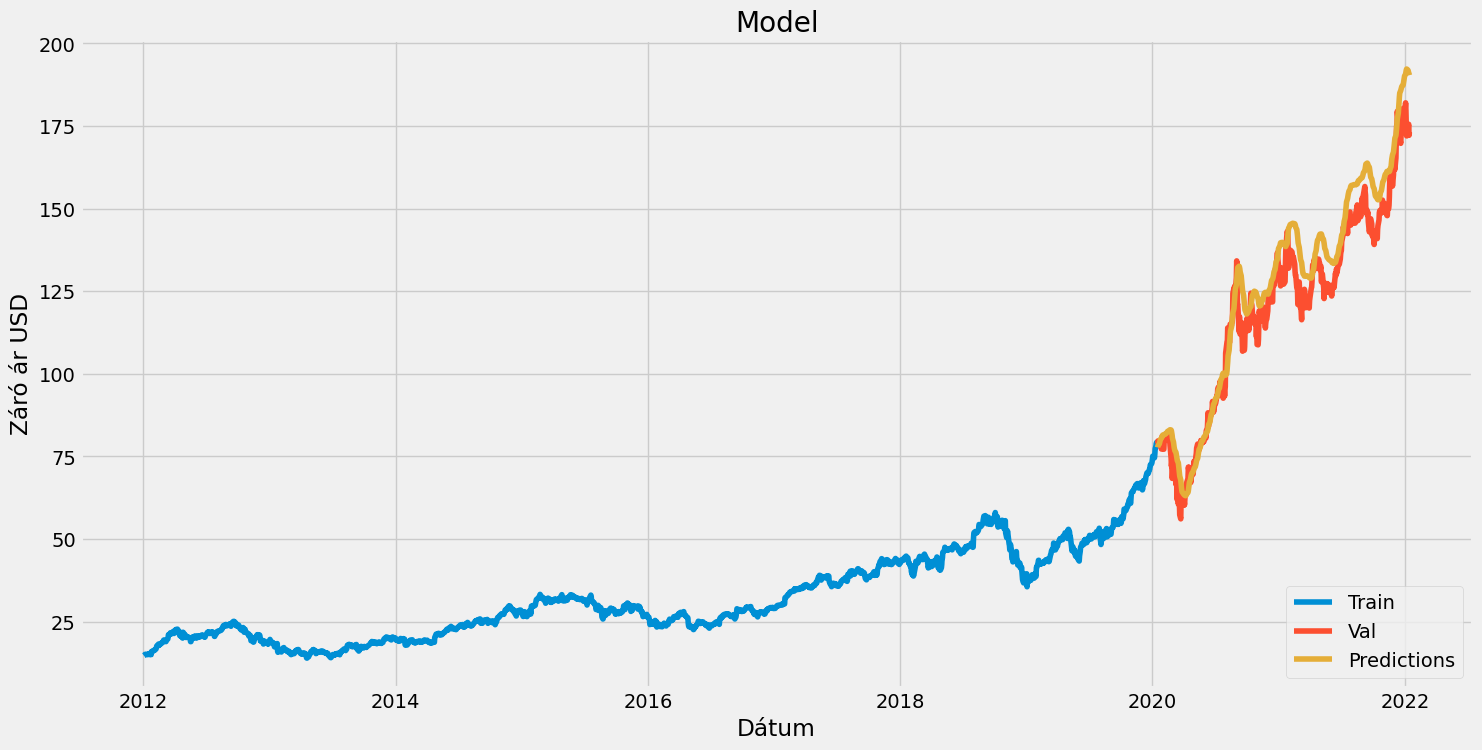

In [127]:
plt.style.use('fivethirtyeight')

plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Dátum')
plt.ylabel('Záró ár USD')
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')

plt.show()

## Show the valid and predicted prices

In [128]:
valid

,Close,Predictions
Date,,
2020-01-16,78.809998,77.725197
2020-01-17,79.682503,78.255547
2020-01-21,79.142502,78.788994
2020-01-22,79.425003,79.275925
2020-01-23,79.807503,79.724396
...,...,...
2022-01-10,172.190002,191.881897
2022-01-11,175.080002,191.446686
2022-01-12,175.529999,191.077652


## Új adatokon

In [129]:
# Download the data
stock_name = 'AAPL'

stock_quote = web.DataReader(stock_name, data_source='yahoo', start='2012-01-01', end='2022-01-10')

# Create a new data frame
new_df = stock_quote.filter(['Close'])

# Set last N day
window_size = 60

# Get the last N day closing price values and covert the dataframe to an array
last_N_days = new_df[-window_size:].values

# Scale the data to be values between 0 and 1
last_N_days_scaled = scaler.transform(last_N_days)

# Create an empty list
X_test = []

# Append the past N days
X_test.append(last_N_days_scaled)

# Convert the X_test data set to a numpy array
X_test = np.array(X_test)

# Reshape the data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Get the predicted scaled price
predicted_price = model.predict(X_test)

# Invert the scaling
predicted_price = scaler.inverse_transform(predicted_price)

# Print the result
print(predicted_price)

[[191.44669]]


## Vesd össze a tényleges adatokkal

In [131]:
# Get the quote
stock_quote_next_day = web.DataReader(stock_name, data_source='yahoo', start='2022-01-11', end='2022-01-11')

print(stock_quote_next_day['Close'])

Date
2022-01-11    175.080002
Name: Close, dtype: float64




```
# JoDeMiro
```

